# Chapter 1: Single cell simulation with current injection (with BioNet)

In this example we will build a network consisting of a single biophysically detailed cell. Then we will run a short simulation with a current injection at the soma of the cell, then look at the output of spikes, membrane potential and calcium flux.


**Note** - scripts and files for running this tutorial can be found in the directory [sources/chapter01/](sources/chapter01)

**requirements:**
* Python 2.7, 3.6+
* bmtk
* NEURON 7.4+

## 1. Building the network

First step is to use the bmtk Network Builder to create and save the network. First we instantiate a network with a name or our choosing (since throughout this tutorial we will use cell models that from the mouse cortex, let's call our network 'mcortex'). 

Once we have a network, we can add a single node by calling the add_nodes method.

In [ ]:
from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('mcortex')
net.add_nodes(cell_name='Scnn1a_473845048',
              potental='exc',
              model_type='biophysical',
              model_template='ctdb:Biophys1.hoc',
              model_processing='aibs_perisomatic',
              dynamics_params='472363762_fit.json',
              morphology='Scnn1a_473845048_m.swc')

Some of the parameters used to create the node are optional and only for our benefit. Others are necessary for when we will eventually run a simulation:
* *cell_name* (optional) - Name/type of cell we will be modeling.
* *potential* (optional) - Use to indicate that it is an excitatory type cell.
* *model_type* - Used by the simulator to indicate that we are using a biophysical cell.
* *dynamics_params* - Model parameters. File will be downloaded from the Allen Cell Types Database. 
* *morphology* - Model morphology. File will be downloaded from the Allen Cell Types Database.
* *model_processing* - A custom function used by the simulator to load the model into NEURON using Allen Cell-Types files for perisomatic models
 
#### Building and saving
The final thing to do is to build and save the network. If successful, we should see a combination of hdf5 and csv files in the './network' directory, these files are used describe the network, and can be saved, stored and run at a later date.

First, it's a good idea to remove any old files in the "network" folder so they don't interfere with the current simulation.

In [ ]:
%%bash
rm network/*

If you get the output:

rm: cannot remove 'network/*': No such file or directory

It's OK. Keep going.

In [ ]:
net.build()
net.save_nodes(output_dir='network')

Use the NetworkBuilder nodes() method to show that a node of our parameters was created

In [ ]:
for node in net.nodes():
    print(node)

## 2. Setting up the simulator enviornment

Now that the network has been built, we can use the BioNet simulator to setup and run it using NEURON. The easiest ways to do this is to copy and modify [existing simulation setup](https://github.com/AllenInstitute/bmtk/tree/develop/docs/examples/bio_14cells), or use the  ```bmtk.utils.sim_setup``` script which can be called from the command-line

```bash
$ python -m bmtk.utils.sim_setup  --report-vars v,cai         \
                                  --network network/          \
                                  --iclamp 0.12,500.0,1000.0  \
                                  --dt 0.1 --tstop 2000.0     \
                                  --include-examples          \
                                  --compile-mechanisms        \
                                  bionet sim_ch01
```
Or call the function directly in python

In [1]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='sim_ch01',      # Where to save the scripts and config files 
                 network_dir='network',    # Location of directory containing network files
                 tstop=2000.0, dt=0.1,     # Run a simulation for 2000 ms at 0.1 ms intervals
                 report_vars=['v', 'cai'], # Tells simulator we want to record membrane potential and calcium traces
                 current_clamp={           # Creates a step current from 500.ms to 1500.0 ms  
                     'amp': 0.120,
                     'delay': 500.0,
                     'duration': 1000.0
                 },
                 include_examples=True,    # Copies components files
                 compile_mechanisms=True   # Will try to compile NEURON mechanisms
                )

ERROR:bmtk.utils.sim_setup:  Was unable to compile mechanism in D:\BMTK\bmtk\docs\tutorial\sim_ch01\components\mechanisms


<div class="alert alert-warning">
**Warning**: You may see an error that it failed while trying to compile the NEURON mechanisms - especially if jupyter is unable to find your NEURON environment path. If this happens you will need to manually compile the mechanisms:  

```
 cd sim_ch01/components/mechanisms  
 nrnivmodl modfiles
```
</div>



This will create the directory **sim_ch01** (feel free to give it a better name or set it to a different locations) with a number of new files and folders. Some of the more important ones include:
* **circuit_config.json** - A configuration file that contains the location of the network files we created above. Plus location of neuron and synpatic models, templates, morphologies and mechanisms required to build our instantiate individual cell models.


* **simulation_config.json** - contains information about the simulation. Including initial conditions and run-time configuration (_run_ and _conditions_). In the _inputs_ section we define what external sources we will use to drive the network (in this case a current clamp). And in the _reports_ section we define the variables (soma membrane potential and calcium) that will be recorded during the simulation 


* **components/biophysical_neuron_models/472363762_fit.json** - The parameter file for the cell we're modeling. Originally [downloaded from the Allen Cell Types Database](http://celltypes.brain-map.org/neuronal_model/download/482934212)


* **components/biophysical_neuron_models/Scnn1a_473845048_m.swc** - The morphology file for our cell. Originally [downloaded from the Allen Cell Types Database](http://celltypes.brain-map.org/neuronal_model/download/482934212)


Modifying these files with a text editor, or swapping out different parameter or morphologies, allows changing the simulation without extra programming.

## 3. Running the simulation

Once our config file is setup we can run a simulation either through the command line:
```bash
$ python run_bionet.py simulation_config.json
```

or through the script

In [2]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('sim_ch01/simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2020-03-16 14:48:22,959 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2020-03-16 14:48:23,171 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2020-03-16 14:48:23,582 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2020-03-16 14:48:23,620 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 2000.000 ms with the time step 0.100 ms


2020-03-16 14:48:23,627 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2020-03-16 14:48:23,645 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2020-03-16 14:48:24,394 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2020-03-16 14:48:24,934 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2020-03-16 14:48:25,801 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2020-03-16 14:48:26,503 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2020-03-16 14:48:26,601 [INFO] Simulation completed in 2.981 seconds 


INFO:NEURONIOUtils:Simulation completed in 2.981 seconds 


<div class="alert alert-warning">
**Warning**: If you get the following error
    argument not a density mechanism name.
You will need to compile the NEURON mechanisms  


```
 cd sim_ch01/components/mechanisms
 nrnivmodl modfiles
 
```
</div>

A quick breakdown of the script:
```python
conf = config.from_json('config.json')
io.setup_output_dir(conf)
nrn.load_neuron_modules(conf)
```
This section loads the configuration file, it setups the output directory and files for writing during the simulation, and loads NEURON mechanisms needed by the cell model(s) during the simulation.

```python
net = bionet.BioNetwork.from_config(conf)
```
Creates a NEURON representation of the network, including cell models that have been converted into their NEURON equivelents.

```python
sim = Simulation.from_config(conf, network=net)
sim.run()
```
Sets up and runs the NEURON simulation. When finished the output - spike times, membrane potential and Calcium influx, will be saved into the output directory as specified in the config.



## 4. Analyzing the run

The results of the simulation are placed into various files as specified in the "output" section of the config file. We can change this before run-time if required.

All simulations will save the spike times of the network cells. These are saved in csv format (output/spikes.txt) or hdf5 format(output/spikes.h5). To get the table of spike times for our single-cell network we can run the following method from the analyzer (gid 0 corresponds to our single cell).

In [3]:
from bmtk.analyzer.spike_trains import to_dataframe
to_dataframe(config_file='sim_ch01/simulation_config.json')

E:\Users\lenovo\Anaconda3\lib\site-packages\bmtk-0.0.8-py3.7.egg\bmtk\simulator\utils\config.py:4: UserWarning: Please use bmtk.simulator.core.simulation_config instead.
  warnings.warn('Please use bmtk.simulator.core.simulation_config instead.')


AttributeError: 'SonataConfig' object has no attribute 'spikes_file'

When setting up the enviornment and config file we specified cell_vars=['v', 'cai']. This indicates to the simulator to also record membrane potential and calcium diffusion (and we can also specify other variables as long as they are supported in NEURON).

In [ ]:
from bmtk.analyzer.cell_vars import plot_report

plot_report(config_file='sim_ch01/simulation_config.json')

In [4]:
import h5py
import pandas as pd

f_spike = h5py.File('sim_ch01/output/spikes.h5') # output file location
f_spike.visit(print) # check groups and members of data

spikes = pd.DataFrame( dict([(key,f_spike['spikes/mcortex/'+key]) for key in f_spike['spikes/mcortex'].keys()]) )
spikes = spikes.sort_values(by='timestamps')
spikes # print pandas dataframe of cell id and spike time

spikes
spikes/mcortex
spikes/mcortex/node_ids
spikes/mcortex/timestamps


,node_ids,timestamps
0,0,554.8
15,0,594.4
14,0,637.1
13,0,683.9
12,0,734.7
11,0,788.7
10,0,844.9
9,0,902.6
8,0,961.2
7,0,1020.4


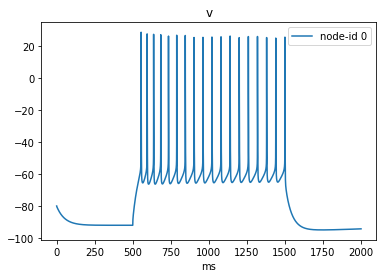

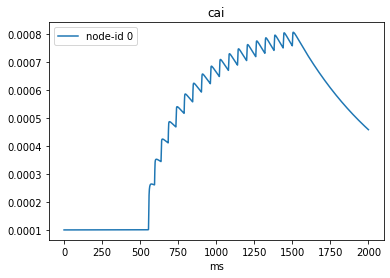

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

node_ids = [0] # cell ids to plot
output_dir = 'sim_ch01/output/' # output directory

def plot_var(var,node_ids,output_dir,net_name):
    f = h5py.File(output_dir+var+'_report.h5')
    t = np.arange(*f['report/'+net_name+'/mapping/time'])
    x = np.array(f['report/'+net_name+'/data'])
    plt.figure()
    plt.plot(t,x[:,node_ids])
    plt.legend(['node-id '+str(i) for i in node_ids])
    plt.xlabel('ms')
    plt.title(var)
    plt.show()

plot_var('v',node_ids,output_dir,'mcortex')
plot_var('cai',node_ids,output_dir,'mcortex')

## 5. Additional Information

### Changing run-time parameters.
By making changes to the config file, we can change the conditions and simulation parameters without having to rebuild the network, modify parameter files, or change our run_bionet script. In fact we can iteratively run multiple simulations without any extra coding, only a text editor to change the json file.

The run section of the config.json contains most of the parameters unique to the simulation:
```json
"run": {
    "dL": 20,
    "nsteps_block": 5000, 
    "spike_threshold": -15,
    "tstop": 2000.0, 
    "dt": 0.1
}
```
* tstop - simulation runtime in milliseconds.
* dt - the time steps of the simulation. decreasing dt should increase accuracy of firing dynamics, but also increase time it takes to complete.
* spike_threshold - used to determine when to count a action potential
* dL - length of segments in a section. the number of segments will be forced to an odd number so the actual length may vary.

Through the conditions section we can adjust simulation temperature (C) and the initial membrane potential of the cells:
```json
"conditions": {
    "celsius": 34.0, 
    "v_init": -80
}
```

And lastly, the input section lets us control stimulus onto the network. There are a number of different options which will be explained in the following tutorials. But even with a simple current injection we can adjust amplitude, delay and stimulation duration and measure the effect on the cell.
```json
"inputs": {
 	"current_clamp": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.120,
      "delay": 500.0,
      "duration": 1000.0
    }
}
```
We can even add multiple injections
```json
"inputs": {
 	"cclamp1": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.150,
      "delay": 0.0,
      "duration": 400.0
    }
    
    "cclamp2": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.300,
      "delay": 500.0,
      "duration": 400.0
    }
    
    "cclamp3": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.450,
      "delay": 1000.0,
      "duration": 400.0
    }
}
```

### Changing cell models
When building the network we defined the cell model and morphology through the 'dynamics_params' and 'morphology_file' options. After building and saving the network, these values were saved in the node-types csv file.

In [ ]:
import pandas as pd
pd.read_csv('network/mcortex_node_types.csv', sep=' ')

If we want to run the simulation on a different cell model, all we have to do is 
1. Download new parameters.json and morphology.swc into components/biophysical
2. Open mcortex_node_types.csv in a text editor and update 'morphology_file' and 'params_file' accordingly.

In our simple one-cell example, it is likely faster to just rebuild the network. However the advantage of the use of the node types becomes clear once we start dealing with a larger network. For example we may have a network of hundreds of thousands of individual cells with tens of thousands of Scnn1a type cells. The process of adjusting/changing the Scnn1a parameter in the csv then starting another simulation only takes seconds, whereas rebuilding the entire network may take hours.